In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = 'data/train/'
VALIDATION_DIR = 'data/validation/'

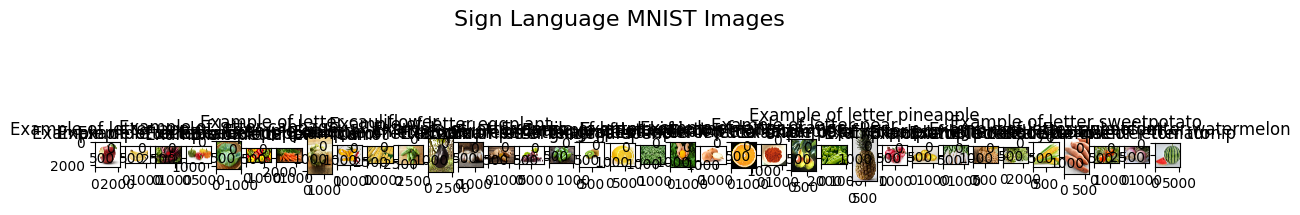

In [3]:
fig, axes = plt.subplots(1, 36, figsize=(14, 3))
fig.suptitle('Sign Language MNIST Images', fontsize=16)

# Plot one image from the first 4 letters
for ii, letter in enumerate(['apple',
'banana',
'beetroot',
'bell pepper',
'cabbage',
'capsicum',
'carrot',
'cauliflower',
'chilli pepper',
'corn',
'cucumber',
'eggplant',
'garlic',
'ginger',
'grapes',
'jalepeno',
'kiwi',
'lemon',
'lettuce',
'mango',
'onion',
'orange',
'paprika',
'pear',
'peas',
'pineapple',
'pomegranate',
'potato',
'raddish',
'soy beans',
'spinach',
'sweetcorn',
'sweetpotato',
'tomato',
'turnip',
'watermelon',]):
    dir = f'./data/train/{letter}'
    img = tf.keras.utils.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of letter {letter}')

In [6]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (4795, 5114, 3)


In [7]:
sample_array[0,:5]

array([[197., 200., 205.],
       [197., 200., 205.],
       [197., 200., 205.],
       [197., 200., 205.],
       [197., 200., 205.]], dtype=float32)

In [ ]:
def train_val_datasets():
    """Create train and validation datasets

    Returns:
        (tf.data.Dataset, tf.data.Dataset): train and validation datasets
    """
    
    train_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        batch_size=16,
        image_size=(224, 224),
        shuffle=True,
        label_mode='int',
        color_mode="rgb",
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=VALIDATION_DIR,
        batch_size=16,
        image_size=(224, 224),
        shuffle=True,
        label_mode='int',
        color_mode="rgb"
    ) 
    return train_dataset, validation_dataset

In [9]:
# Create train and validation datasets
train_dataset, validation_dataset = train_val_datasets()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")   

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Images of train dataset have shape: (None, 224, 224, 3)
Labels of train dataset have shape: (None,)
Images of validation dataset have shape: (None, 224, 224, 3)
Labels of validation dataset have shape: (None,)


In [10]:
augmentation_model = tf.keras.Sequential([ 
		tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]) 

In [11]:
# Define the path to the inception v3 weights
LOCAL_WEIGHTS_FILE = './model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3( 
        include_top=False, 
        input_shape=(224, 224, 3),
        weights=LOCAL_WEIGHTS_FILE
    ) 

# Make all the layers in the pre-trained model non-trainable
pre_trained_model.trainable = False

In [13]:
pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

In [14]:
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
last_desired_layer = pre_trained_model.get_layer('mixed7')
last_output = last_desired_layer.output

print('last layer output shape: ', last_output.shape)

last layer output shape:  (None, 12, 12, 768)


In [ ]:
# Define the input shape
# inputs = tf.keras.Input(shape=(224, 224, 3))

# Apply data augmentation if needed
x = tf.keras.layers.RandomFlip('horizontal')(last_output)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomTranslation(0.1, 0.1)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

# Flatten the output layer of the pretrained model to 1 dimension
x = tf.keras.layers.Flatten()(last_output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(36, activation='sigmoid')(x)          

# Create the complete model by using the Model class
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [20]:
# Define the preprocess function
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Apply the preprocessing to all datasets
training_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

In [21]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 224, 224, 3)
Output shape: (None, 36)


In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 122,259,396 (466.38 MB)

 Trainable params: 113,284,132 (432.14 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [23]:
for images, labels in train_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels
	
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")# Train your model

predictions have shape: (16, 36)


In [24]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.99:
            self.model.stop_training = True
            print("\nReached 99.0% accuracy so cancelling training!")

In [25]:
# Run this and see how many epochs it takes before the callback fires
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 100,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/100
195/195 - 372s - 2s/step - accuracy: 0.4138 - loss: 4.0451 - val_accuracy: 0.8718 - val_loss: 0.4591
Epoch 2/100
195/195 - 351s - 2s/step - accuracy: 0.8148 - loss: 0.7403 - val_accuracy: 0.9088 - val_loss: 0.4101
Epoch 3/100
195/195 - 300s - 2s/step - accuracy: 0.9008 - loss: 0.4406 - val_accuracy: 0.9630 - val_loss: 0.2537
Epoch 4/100
195/195 - 264s - 1s/step - accuracy: 0.9297 - loss: 0.3568 - val_accuracy: 0.9459 - val_loss: 0.3867
Epoch 5/100
195/195 - 270s - 1s/step - accuracy: 0.9406 - loss: 0.3279 - val_accuracy: 0.9630 - val_loss: 0.2266
Epoch 6/100
195/195 - 269s - 1s/step - accuracy: 0.9576 - loss: 0.2745 - val_accuracy: 0.9544 - val_loss: 0.3298
Epoch 7/100
195/195 - 266s - 1s/step - accuracy: 0.9608 - loss: 0.2133 - val_accuracy: 0.9630 - val_loss: 0.3960
Epoch 8/100
195/195 - 274s - 1s/step - accuracy: 0.9657 - loss: 0.2276 - val_accuracy: 0.9601 - val_loss: 0.2734
Epoch 9/100
195/195 - 282s - 1s/step - accuracy: 0.9653 - loss: 0.2217 - val_accuracy: 0.9601 - 

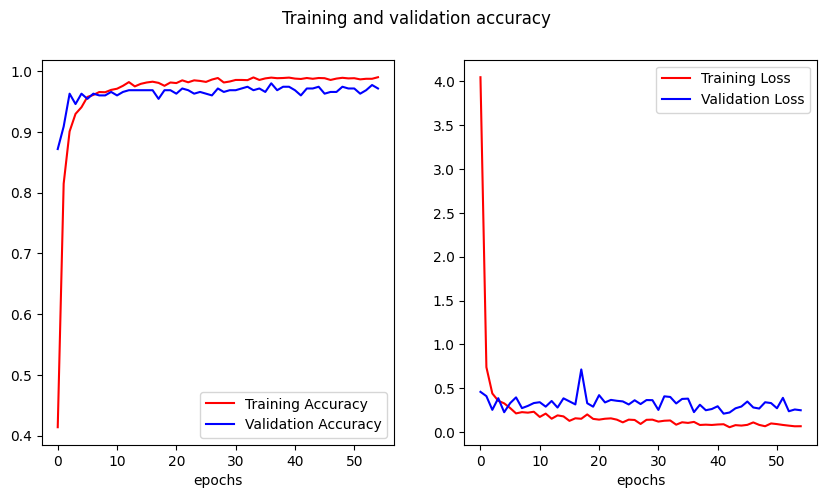

In [26]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [27]:
model.save("model.h5")

Found 359 files belonging to 36 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 513ms/step


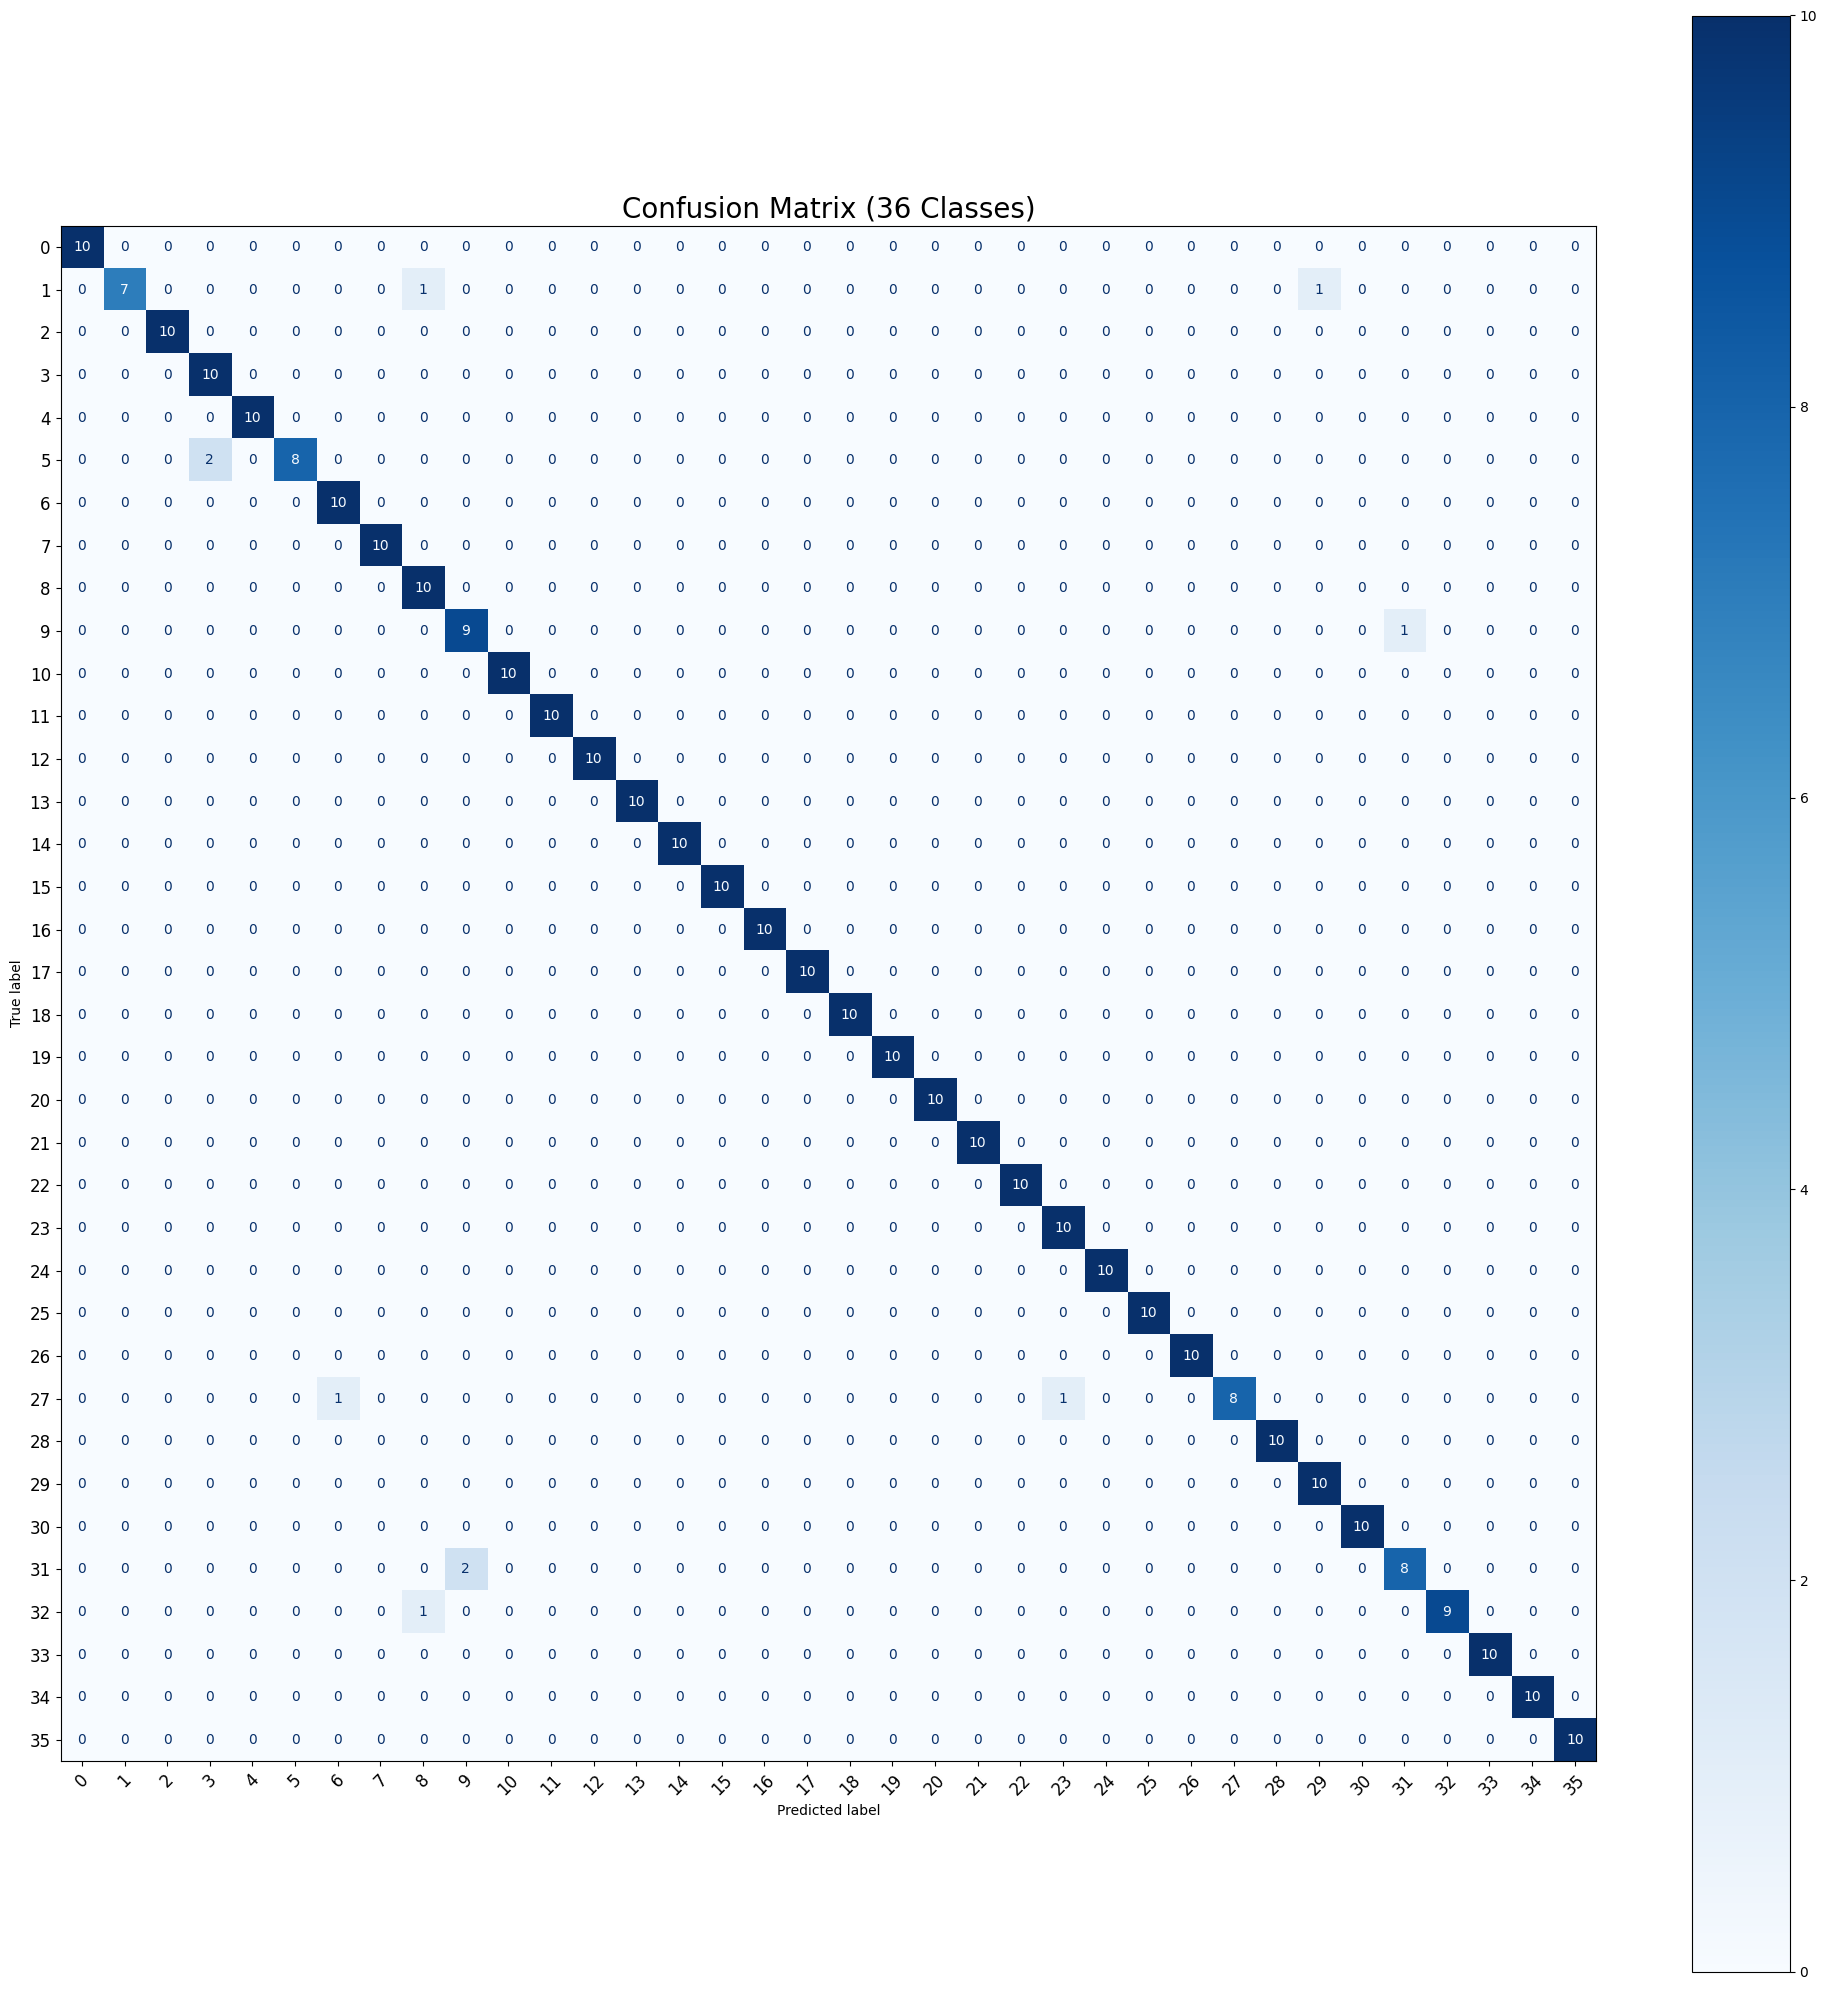

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
TEST_DIR = 'data/test/'

preprocess_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
test_dataset = test_dataset.map(lambda x, y: (preprocess_layer(x), y))


# Ekstrak label sebenarnya
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Prediksi dengan model
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(36))

# Visualisasi confusion matrix dengan ukuran besar
fig, ax = plt.subplots(figsize=(20, 20))  # Memastikan ukuran besar
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=True)
plt.title("Confusion Matrix (36 Classes)", fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()  # Pastikan layout optimal
plt.show()# Print accuracy per class
